귀찮아서 글씨는 안썼습니ㄷ ㅏ

In [21]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [22]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


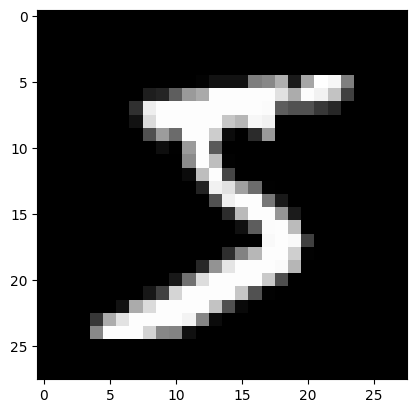

In [23]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [19]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인합니다
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의하세요
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당합니다
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눕니다
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [16]:
import torch
import math

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# 이 예제에서, 출력 y는 (x, x^2, x^3)의 선형 함수이므로, 선형 계층 신경망으로 간주할 수 있습니다.
# (x, x^2, x^3)를 위한 텐서를 준비합니다.
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# 위 코드에서, x.unsqueeze(-1)은 (2000, 1)의 shape을, p는 (3,)의 shape을 가지므로,
# 이 경우 브로드캐스트(broadcast)가 적용되어 (2000, 3)의 shape을 갖는 텐서를 얻습니다.

# nn 패키지를 사용하여 모델을 순차적 계층(sequence of layers)으로 정의합니다.
# nn.Sequential은 다른 Module을 포함하는 Module로, 포함되는 Module들을 순차적으로 적용하여
# 출력을 생성합니다. 각각의 Linear Module은 선형 함수(linear function)를 사용하여 입력으로부터
# 출력을 계산하고, 내부 Tensor에 가중치와 편향을 저장합니다.
# Flatten 계층은 선형 계층의 출력을 `y` 의 shape과 맞도록(match) 1D 텐서로 폅니다(flatten).
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

# 또한 nn 패키지에는 주로 사용되는 손실 함수(loss function)들에 대한 정의도 포함되어 있습니다;
# 여기에서는 평균 제곱 오차(MSE; Mean Squared Error)를 손실 함수로 사용하겠습니다.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(2000):

    # 순전파 단계: x를 모델에 전달하여 예측값 y를 계산합니다. Module 객체는 __call__ 연산자를
    # 덮어써서(override) 함수처럼 호출할 수 있도록 합니다. 이렇게 함으로써 입력 데이터의 텐서를 Module에 전달하여
    # 출력 데이터의 텐서를 생성합니다.
    y_pred = model(xx)

    # 손실을 계산하고 출력합니다. 예측한 y와 정답인 y를 갖는 텐서들을 전달하고,
    # 손실 함수는 손실(loss)을 갖는 텐서를 반환합니다.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 역전파 단계를 실행하기 전에 변화도(gradient)를 0으로 만듭니다.
    model.zero_grad()

    # 역전파 단계: 모델의 학습 가능한 모든 매개변수에 대해 손실의 변화도를 계산합니다.
    # 내부적으로 각 Module의 매개변수는 requires_grad=True일 때 텐서에 저장되므로,
    # 아래 호출은 모델의 모든 학습 가능한 매개변수의 변화도를 계산하게 됩니다.
    loss.backward()

    # 경사하강법을 사용하여 가중치를 갱신합니다.
    # 각 매개변수는 텐서이므로, 이전에 했던 것처럼 변화도에 접근할 수 있습니다.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# list의 첫번째 항목에 접근하는 것처럼 `model` 의 첫번째 계층(layer)에 접근할 수 있습니다.
linear_layer = model[0]

# 선형 계층에서, 매개변수는 `weights` 와 `bias` 로 저장됩니다.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 216.63958740234375
199 146.65798950195312
299 100.26051330566406
399 69.49356079101562
499 49.08759307861328
599 35.55089569091797
699 26.569040298461914
799 20.608112335205078
899 16.651140213012695
999 14.023717880249023
1099 12.278613090515137
1199 11.119219779968262
1299 10.3486967086792
1399 9.836479187011719
1499 9.495850563049316
1599 9.269244194030762
1699 9.11844539642334
1799 9.018051147460938
1899 8.951171875
1999 8.906606674194336
Result: y = -0.003762229345738888 + 0.8482215404510498 x + 0.0006490476080216467 x^2 + -0.09211859107017517 x^3


In [15]:
import torch
import math


class LegendrePolynomial3(torch.autograd.Function):
    """
    torch.autograd.Function을 상속받아 사용자 정의 autograd Function을 구현하고,
    텐서 연산을 하는 순전파 단계와 역전파 단계를 구현해보겠습니다.
    """

    @staticmethod
    def forward(ctx, input):
        """
        순전파 단계에서는 입력을 갖는 텐서를 받아 출력을 갖는 텐서를 반환합니다.
        ctx는 컨텍스트 객체(context object)로 역전파 연산을 위한 정보 저장에 사용합니다.
        ctx.save_for_backward 메소드를 사용하여 역전파 단계에서 사용할 어떤 객체도
        저장(cache)해 둘 수 있습니다.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        역전파 단계에서는 출력에 대한 손실(loss)의 변화도(gradient)를 갖는 텐서를 받고,
        입력에 대한 손실의 변화도를 계산해야 합니다.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
# requires_grad=False가 기본값으로 설정되어 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할
# 필요가 없음을 나타냅니다.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 가중치를 갖는 임의의 텐서를 생성합니다. 3차 다항식이므로 4개의 가중치가 필요합니다:
# y = a + b * P3(c + d * x)
# 이 가중치들이 수렴(convergence)하기 위해서는 정답으로부터 너무 멀리 떨어지지 않은 값으로
# 초기화가 되어야 합니다.
# requires_grad=True로 설정하여 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할 필요가
# 있음을 나타냅니다.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-6
for t in range(2000):
    # 사용자 정의 Function을 적용하기 위해 Function.apply 메소드를 사용합니다.
    # 여기에 'P3'라고 이름을 붙였습니다.
    P3 = LegendrePolynomial3.apply

    # 순전파 단계: 연산을 하여 예측값 y를 계산합니다;
    # 사용자 정의 autograd 연산을 사용하여 P3를 계산합니다.
    y_pred = a + b * P3(c + d * x)

    # 손실을 계산하고 출력합니다.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # autograd를 사용하여 역전파 단계를 계산합니다.
    loss.backward()

    # 경사하강법(gradient descent)을 사용하여 가중치를 갱신합니다.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # 가중치 갱신 후에는 변화도를 직접 0으로 만듭니다.
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

99 209.95834350585938
199 144.66018676757812
299 100.70249938964844
399 71.03519439697266
499 50.978511810302734
599 37.403133392333984
699 28.206867218017578
799 21.97318458557129
899 17.7457275390625
999 14.877889633178711
1099 12.93176555633545
1199 11.610918045043945
1299 10.71425724029541
1399 10.10548210144043
1499 9.692105293273926
1599 9.411375999450684
1699 9.220745086669922
1799 9.091285705566406
1899 9.003361701965332
1999 8.943641662597656
Result: y = -6.71270206087371e-10 + -2.208526849746704 * P3(-3.392665037793563e-10 + 0.2554861009120941 x)


In [14]:
import torch
import math

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
# requires_grad=False가 기본값으로 설정되어 역전파 단계 중에 이 텐서들에 대한 변화도를
# 계산할 필요가 없음을 나타냅니다.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 가중치를 갖는 임의의 텐서를 생성합니다. 3차 다항식이므로 4개의 가중치가 필요합니다:
# y = a + b x + c x^2 + d x^3
# requires_grad=True로 설정하여 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할 필요가
# 있음을 나타냅니다.
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 텐서들 간의 연산을 사용하여 예측값 y를 계산합니다.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 텐서들간의 연산을 사용하여 손실(loss)을 계산하고 출력합니다.
    # 이 때 손실은 (1,) shape을 갖는 텐서입니다.
    # loss.item() 으로 손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # autograd 를 사용하여 역전파 단계를 계산합니다. 이는 requires_grad=True를 갖는
    # 모든 텐서들에 대한 손실의 변화도를 계산합니다.
    # 이후 a.grad와 b.grad, c.grad, d.grad는 각각 a, b, c, d에 대한 손실의 변화도를
    # 갖는 텐서가 됩니다.
    loss.backward()

    # 경사하강법(gradient descent)을 사용하여 가중치를 직접 갱신합니다.
    # torch.no_grad()로 감싸는 이유는, 가중치들이 requires_grad=True 지만
    # autograd에서는 이를 추적하지 않을 것이기 때문입니다.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # 가중치 갱신 후에는 변화도를 직접 0으로 만듭니다.
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 1339.68310546875
199 934.208984375
299 652.83203125
399 457.38775634765625
499 321.5091552734375
599 226.9602508544922
699 161.1140899658203
799 115.21985626220703
899 83.20716094970703
999 60.86021423339844
1099 45.24931716918945
1199 34.336463928222656
1299 26.702730178833008
1399 21.35935401916504
1499 17.6169376373291
1599 14.994261741638184
1699 13.15528392791748
1799 11.865140914916992
1899 10.959592819213867
1999 10.323690414428711
Result: y = -0.039178524166345596 + 0.8680986762046814 x + 0.0067589464597404 x^2 + -0.09494594484567642 x^3


In [13]:
import torch
import math


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요

# 무작위로 입력과 출력 데이터를 생성합니다
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 무작위로 가중치를 초기화합니다
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 예측값 y를 계산합니다
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 손실(loss)을 계산하고 출력합니다
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # 손실에 따른 a, b, c, d의 변화도(gradient)를 계산하고 역전파합니다.
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # 가중치를 갱신합니다.
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 234.9934539794922
199 165.87246704101562
299 117.97553253173828
399 84.75245666503906
499 61.68629455566406
599 45.65703582763672
699 34.508026123046875
799 26.746747970581055
899 21.339385986328125
999 17.568984985351562
1099 14.937957763671875
1199 13.100661277770996
1299 11.816713333129883
1399 10.918853759765625
1499 10.290592193603516
1599 9.850676536560059
1699 9.542475700378418
1799 9.326428413391113
1899 9.174901008605957
1999 9.068567276000977
Result: y = -0.015927929431200027 + 0.8615978360176086 x + 0.0027478307019919157 x^2 + -0.0940212532877922 x^3


In [12]:
import numpy as np
import math

# 무작위로 입력과 출력 데이터를 생성합니다
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# 무작위로 가중치를 초기화합니다
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 예측값 y를 계산합니다
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 손실(loss)을 계산하고 출력합니다
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)

    # 손실에 따른 a, b, c, d의 변화도(gradient)를 계산하고 역전파합니다.
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # 가중치를 갱신합니다.
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

99 249.74266740550567
199 176.02667993340148
299 124.97403706004654
399 89.5813887179027
499 65.02163005227827
599 47.96317918090457
699 36.10419741546111
799 27.852656312903033
899 22.106335401377287
999 18.101368394835422
1099 15.307864527862819
1199 13.35789489160937
1299 11.9957551964036
1399 11.043578068425074
1499 10.377533438580398
1599 9.911340410585748
1699 9.584833290611698
1799 9.356024973161508
1899 9.195592846770056
1999 9.083044357220496
Result: y = -0.016348834302341637 + 0.8516601340313362 x + 0.0028204459629309862 x^2 + -0.09260770242251419 x^3


In [11]:
# -*- coding: utf-8 -*-
import numpy as np
import math

# 무작위로 입력과 출력 데이터를 생성합니다
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# 무작위로 가중치를 초기화합니다
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 예측값 y를 계산합니다
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 손실(loss)을 계산하고 출력합니다
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)

    # 손실에 따른 a, b, c, d의 변화도(gradient)를 계산하고 역전파합니다.
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # 가중치를 갱신합니다.
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

99 1327.026213038488
199 892.2779754727796
299 601.3527593219981
399 406.5381974467248
499 275.9902110073885
599 188.44334015553497
699 129.68820987082108
799 90.22442883513747
899 63.69595465726233
999 45.84755271364681
1099 33.828437772824074
1199 25.7273369405814
1299 20.261886775222223
1399 16.571008646192265
1499 14.076032872963973
1599 12.387746093770339
1699 11.24413308270977
1799 10.468647177241687
1899 9.94221935831638
1999 9.584468146646168
Result: y = 0.019978214751816895 + 0.8370320603064817 x + -0.0034465744836168323 x^2 + -0.09052698631754034 x^3


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)


net.to(device)

inputs, labels = data[0].to(device), data[1].to(device)

del dataiter

cpu


In [6]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.186
[1,  4000] loss: 1.861
[1,  6000] loss: 1.675
[1,  8000] loss: 1.593
[1, 10000] loss: 1.531
[1, 12000] loss: 1.488
[2,  2000] loss: 1.430
[2,  4000] loss: 1.389
[2,  6000] loss: 1.373
[2,  8000] loss: 1.332
[2, 10000] loss: 1.312
[2, 12000] loss: 1.305
Finished Training


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

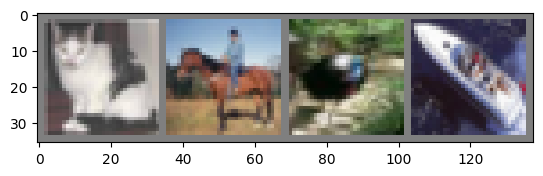

cat   horse bird  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 73055600.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
